In [6]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os

def visualiseCorr(corr):
    fig, ax = plt.subplots(figsize=(40,15))
    image = corr
    ax.imshow(image, cmap=plt.cm.gray, interpolation='nearest')
    ax.set_title('dropped spines')
    
    # Move left and bottom spines outward by 10 points
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    plt.show()
    
def threshhold(corr, thld):
    w = len(corr[0])
    h = len(corr)
    tcorr = np.zeros((h, w))
    for i_index, i in enumerate(corr):
        for j_index, j in enumerate(i):
            if j < thld:
                tcorr[i_index][j_index] = 0
            else:
                tcorr[i_index][j_index] = j
    return tcorr
    
def postprocess(corr, windowsize):
    w = len(corr[0])
    h = len(corr)
    #print (w,h)
    M = 4
    ncorr = np.zeros((M*h, 2*w+windowsize))
    for i,j in enumerate(corr):
        #print (len(ncorr[i][-w:]), len(j))
        for k in range(M):
            ncorr[i*M+k][-w-((1+i)*windowsize):-(1+i)*windowsize] = j
        #print(len(ncorr[i][-w-((1+i)*windowsize):-(1+i)*windowsize]))
    
    return(ncorr)

In [7]:
from ipyparallel import Client
import numpy as np
c = Client(profile='default')
dview = c[:]

@dview.parallel(block=True)
def correlateblock(data):
    import numpy as np
    res = []
    for d in data:
        a = d['a']
        b = d['b']
        block = d['block']
        #if not block % 5:
        #print(block)
        windowsize = d['windowsize']
        corr = np.zeros(len(a)-windowsize)
        y = b[block*windowsize:(1+block)*windowsize]
        for j in range(len(a)-windowsize):
            x = a[0+j:windowsize+j]
            corr[j] = np.corrcoef(x, y)[0,1]
            #if not j % 5:
            #    print(j, end='')
        res.append({'block':block, 'corr':corr})
    return res
    

def correlate(a, b, windowsize): #, dump="dump", start=0, stop=0):
    corr = np.zeros((int(len(b)/windowsize), len(a)-windowsize))
    totalJobs = int(len(b)/windowsize) * len(a)-windowsize
    
    
    jobs = [{'a':a, 'b':b, 'block':i, 'windowsize':windowsize} for i in range(0, int(len(b)/windowsize))]    
    print("total jobs:", len(jobs))#print([i for i in range(0, int(len(b)/windowsize))])
    chunk = 4
    for i in range(int(len(jobs)/chunk)):
        print(4*i,4*(i+1))
        data = correlateblock(jobs[4*i:4*(i+1)])
        for i in data:
            corr[i['block']] = i['corr']
    return corr

In [8]:
length = 1000
windowsize = 40
a = np.random.uniform(size=(length))
b = np.random.uniform(size=(length))
b[-500:] = a[-500:]
blocks = int(len(b)/windowsize)

In [9]:
corr = correlate(a, a, windowsize)

total jobs: 25
0 4
4 8
8 12
12 16
16 20
20 24


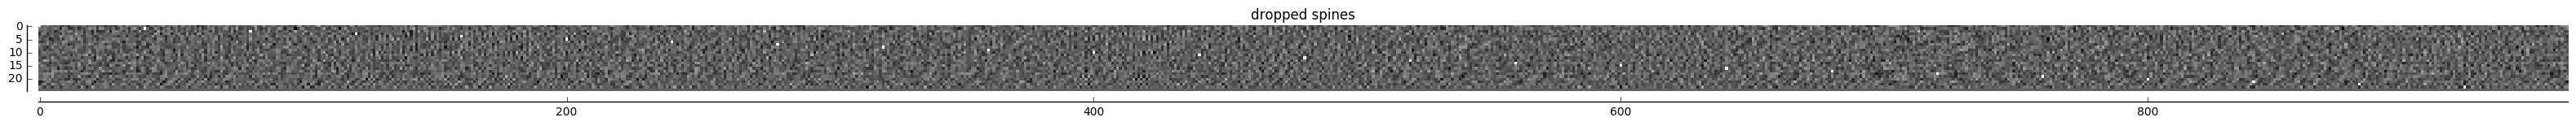

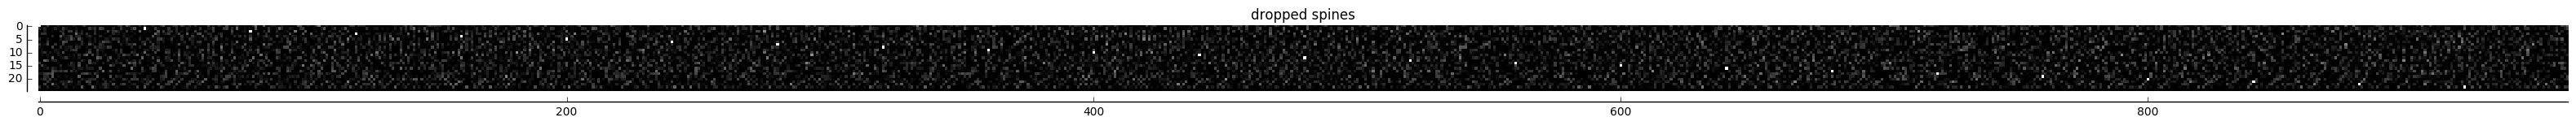

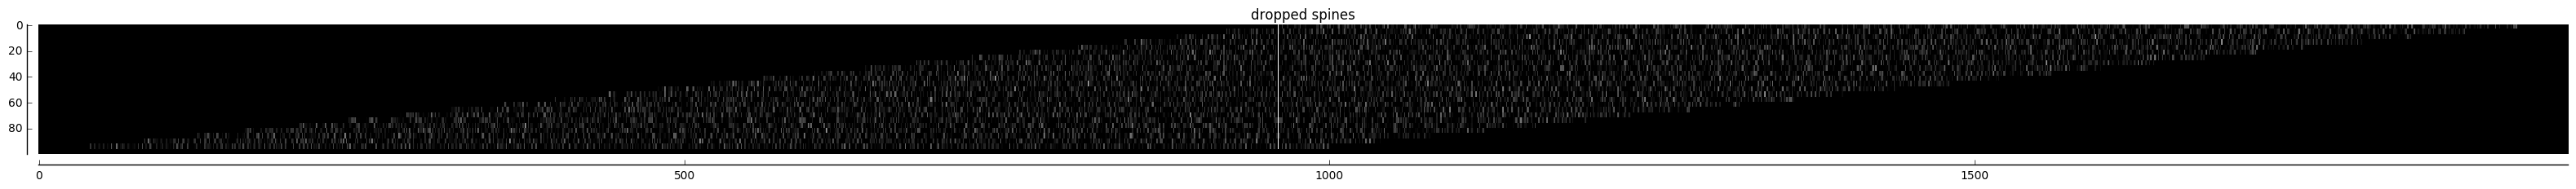

In [10]:
visualiseCorr(corr)
tcorr = threshhold(corr, 0.005)
visualiseCorr(tcorr)
ncorr = postprocess(tcorr, windowsize)
visualiseCorr(ncorr)

In [11]:
master = np.genfromtxt(
    'master.csv',           # file name
    skip_header=5,          # lines to skip at the top
    skip_footer=0,          # lines to skip at the bottom
    delimiter=',',          # column delimiter
    dtype='float64',        # data type
    filling_values=0,       # fill missing values with 0
    usecols = (0,1),    # columns to read
    names=['Time', ',Ampl'])     # column names
slave = np.genfromtxt(
    'slave.csv',           # file name
    skip_header=5,          # lines to skip at the top
    skip_footer=0,          # lines to skip at the bottom
    delimiter=',',          # column delimiter
    dtype='float32',        # data type
    filling_values=0,       # fill missing values with 0
    usecols = (0,1),    # columns to read
    names=['Time', 'Ampl'])     # column names

In [12]:
a = master['Ampl']
b = slave['Ampl']
print(len(a), len(b))

400002 400002


In [13]:
windowsize = 1000
corr = correlate(a, b, windowsize)

total jobs: 400
0 4
4 8
8 12
12 16
16 20
20 24
24 28
28 32
32 36
36 40
40 44
44 48
48 52
52 56
56 60
60 64
64 68
68 72
72 76
76 80
80 84
84 88
88 92
92 96
96 100
100 104
104 108
108 112
112 116
116 120
120 124
124 128
128 132
132 136
136 140
140 144
144 148
148 152
152 156
156 160
160 164
164 168
168 172
172 176
176 180
180 184
184 188
188 192
192 196
196 200
200 204
204 208
208 212
212 216
216 220
220 224
224 228
228 232
232 236
236 240
240 244
244 248
248 252
252 256
256 260
260 264
264 268
268 272
272 276
276 280
280 284
284 288
288 292
292 296
296 300
300 304
304 308
308 312
312 316
316 320
320 324
324 328
328 332
332 336
336 340
340 344
344 348
348 352
352 356
356 360
360 364
364 368
368 372
372 376
376 380
380 384
384 388
388 392
392 396
396 400
